In [3]:
import pandas as pd
import numpy as np
import re
import string
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Global Parameters
stop_words = set(stopwords.words('english'))

In [4]:
### Define all functions needed

# Pre-processing Tweets text data
def preprocess_tweet_text(tweet):
    # Letter casing: Converting all letters to lower case (or upper case )
    tweet = str(tweet).lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords, Tokenizing: Turning the tweets into tokens. Tokens are words separated by spaces in a text
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    #ps = PorterStemmer()
    #stemmed_words = [ps.stem(w) for w in filtered_words]
    #lemmatizer = WordNetLemmatizer()
    #lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    
    return " ".join(filtered_words)

# Vectorizing Data: Vectorizing is the process to convert tokens to numbers
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector
    
### Important Note: I am using the dataset as the corpus to make a tf-idf vector. The same vector structure should be used for training and testing purposes.


In [5]:
# Load dataset
dataset = pd.read_csv("train.csv", encoding='UTF-8')
#Preprocess data
dataset['text'] = dataset['text'].apply(preprocess_tweet_text)

dataset

,text,sentiment
0,oh marly im sorry hope find soon 3 3,neutral
1,playing ghost online really interesting new up...,positive
2,cleaning house family comming later today,neutral
3,got ta restart computer thought win7 supposed ...,neutral
4,see wat mean bout foll0w friidays called lose ...,neutral
...,...,...
27443,like drew said give tc chance miss thomas move...,negative
27444,rec gametrying crythe pain muchi need himcant ...,negative
27445,sure ill try n keep p enjoy studying cya,positive
27446,naw pretty tame 1 guy costume voyagerstyle med...,neutral


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27448 entries, 0 to 27447
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27448 non-null  object
 1   sentiment  27448 non-null  object
dtypes: object(2)
memory usage: 429.0+ KB


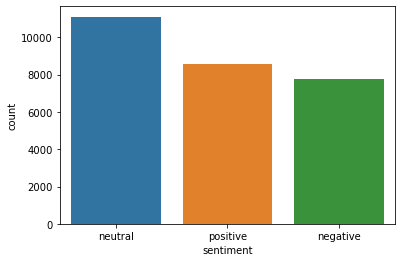

In [7]:
import seaborn as sns
sns.countplot(x = 'sentiment', data = dataset)

In [8]:
## Split dataset into Train, Test
# Same tf vector will be used for Testing sentiments on unseen trending data
tf_vector = get_feature_vector(np.array(dataset.iloc[:, 0]).ravel())
X = tf_vector.transform(np.array(dataset.iloc[:, 0]).ravel())
y = np.array(dataset.iloc[:, 1]).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=75)

# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
print(accuracy_score(y_test, y_predict_nb))

# Training Logistics Regression model
LR_model = LogisticRegression(solver='lbfgs') # For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))

0.6207650273224044
0.6808743169398908


In [9]:
# Try to predict the outcome on a new document we need to extract the features using almost the same feature extracting chain as before. The difference is that we call transform instead of fit_transform on the transformers, since they have already been fit to the training set
docs_new = ['God is love', 'OpenGL on the GPU is fast']
X_new = tf_vector.transform(docs_new)
print(X_new) #  the vocabulary size of corpus is relatively small so there are some missing value

(0, 14518)	0.5600113575466521
  (0, 10254)	0.8284849301096284
  (1, 10436)	0.815733292242071
  (1, 8813)	0.5784282115594915


In [10]:
predicted = LR_model.predict(X_new)
print(predicted)

for doc, sentiment in zip(docs_new, predicted):
    print('%r => %s' % (doc, sentiment))

['positive' 'neutral']
'God is love' => positive
'OpenGL on the GPU is fast' => neutral


** Getting the model ready for deployment **

In [11]:
# Save our trained classifier model to disk using pickle. It can then be reloaded later on and used exactly as if we had trained it.
import pickle 

with open('Sentiment_LRmodel.pkl', 'wb') as file:
    pickle.dump(LR_model, file)
# create a pkl file

In [12]:
vector = TfidfVectorizer(sublinear_tf=True)
vector.fit_transform(np.array(dataset.iloc[:, 0]).ravel())
a = vector.transform(docs_new)
print(a)


(0, 14518)	0.5600113575466521
  (0, 10254)	0.8284849301096284
  (1, 10436)	0.815733292242071
  (1, 8813)	0.5784282115594915


In [13]:
with open('tf_idf.pkl','wb') as file:
    pickle.dump(vector, file)

In [14]:
from joblib import dump
dump(LR_model, 'model.joblib')
dump(vector,'vector.joblib')

['vector.joblib']

In [15]:
vector.vocabulary_

{'oh': 17153,
 'marly': 14999,
 'im': 12134,
 'sorry': 22237,
 'hope': 11677,
 'find': 9048,
 'soon': 22182,
 'playing': 18471,
 'ghost': 10075,
 'online': 17310,
 'really': 19616,
 'interesting': 12443,
 'new': 16532,
 'updates': 25466,
 'kirin': 13460,
 'pet': 18146,
 'metamorph': 15384,
 'third': 23981,
 'job': 12969,
 'cant': 4480,
 'wait': 25999,
 'dragon': 7551,
 'cleaning': 5278,
 'house': 11771,
 'family': 8752,
 'comming': 5594,
 'later': 13807,
 'today': 24312,
 'got': 10401,
 'ta': 23415,
 'restart': 20063,
 'computer': 5678,
 'thought': 24043,
 'win7': 26652,
 'supposed': 23213,
 'put': 19260,
 'end': 8166,
 'constant': 5790,
 'rebootiness': 19649,
 'see': 21017,
 'wat': 26143,
 'mean': 15193,
 'bout': 3750,
 'foll0w': 9309,
 'friidays': 9622,
 'called': 4396,
 'lose': 14470,
 'f0llowers': 8657,
 'friday': 9581,
 'smh': 21943,
 'free': 9520,
 'fillin': 9016,
 'app': 1964,
 'ipod': 12536,
 'fun': 9709,
 'addicted': 1176,
 'way': 26195,
 'malaysiano': 14853,
 'internet': 1245